In [1]:
import glob
import os
import re
from nltk.tokenize import word_tokenize
import nltk
import tarfile
nltk.download('punkt')
!pip install tensorflow==1.15
!pip install "tensorflow_hub>=0.6.0"
!pip3 install tensorflow_text==1.15

import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
from sklearn import preprocessing
import keras
import numpy as np

from keras.layers import Input, Lambda, Dense
from keras.models import Model
import keras.backend as K
!pip install keras_metrics
import keras_metrics
!pip install transformers
from transformers import BertTokenizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
     |████████████████████████████████| 412.3MB 37kB/s 
     |████████████████████████████████| 512kB 37.6MB/s 
     |████████████████████████████████| 3.8MB 46.7MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=094bcfc1e2b95d04ee4f203694398c9ae0ad179e95602124d391d7464b387dfb
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.2.1
    Uni

Using TensorFlow backend.


     |████████████████████████████████| 645kB 3.4MB/s 
     |████████████████████████████████| 1.0MB 15.7MB/s 
     |████████████████████████████████| 3.8MB 19.5MB/s 
     |████████████████████████████████| 890kB 27.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=db8ef9f63cc9d52c0fd3b6f464afa644f45465ca1c2e4b004c7f67eebb7b7a41
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
link = 'https://drive.google.com/open?id=1g6zN3aoYZKhc9IcqsBg8SWfJwHwayr3j'
fluff, id = link.split('=')
print (id)
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('aclImdb_v1.tar.gz')  
if os.path.isdir('aclImdb'):
    print("Dataset directory exists, taking no action")
else:    
    if not os.path.isfile('aclImdb_v1.tar.gz'):
        print("Downloading dataset")
        # !wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
        # # wget.download('http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz')
    else:
        print("Dataset already downloaded")
    
    print("Unpacking dataset")
    # !tar -xf aclImdb_v1.tar.gz 
    tar = tarfile.open("aclImdb_v1.tar.gz")
    tar.extractall()
    tar.close()
    print("Dataset unpacked in aclImdb")


1g6zN3aoYZKhc9IcqsBg8SWfJwHwayr3j
Dataset already downloaded
Unpacking dataset
Dataset unpacked in aclImdb


In [0]:
positive_sample_file_list = glob.glob(os.path.join('aclImdb/train/pos', "*.txt"))
# positive_sample_file_list = positive_file_list[:SAMPLE_SIZE]

negative_sample_file_list = glob.glob(os.path.join('aclImdb/train/neg', "*.txt"))
# negative_sample_file_list = negative_file_list[:SAMPLE_SIZE]

# load doc into memory
# regex to clean markup elements 
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r', encoding='utf8')
    # read all text
    text = re.sub('<[^>]*>', ' ', file.read())
    #text = file.read()
    # close the file
    file.close()
    return text


positive_strings = [load_doc(x) for x in positive_sample_file_list]
negative_strings = [load_doc(x) for x in negative_sample_file_list]

positive_labels = [1 for x in positive_sample_file_list]
negative_labels = [0 for x in negative_sample_file_list]

# positive_tokenized = [word_tokenize(s) for s in positive_strings]
# negative_tokenized = [word_tokenize(s) for s in negative_strings]

In [0]:
sentences = positive_strings + negative_strings
labels = positive_labels + negative_labels

In [0]:
import pandas as pd
df = pd.DataFrame(
    {'sentences': sentences,
     'sentiment': labels
    })
# df = df.sample(5000)

In [0]:
df.head()

,sentences,sentiment
0,Page 3 is one of those films Madhur Bhandarkar...,1
1,Terrfic film with a slightyly slow start - giv...,1
2,"I went to see Fever Pitch with my Mom, and I c...",1
3,Years ago I did follow a soap on TV. So I was ...,1
4,I loved this movie. I knew it would be chocked...,1


In [0]:
df = df.sample(frac=1).reset_index(drop=True)

In [0]:
df.head()

,sentences,sentiment
0,"It's 1982, Two years after the Iranian Embassy...",0
1,As a convert into the Church of Jesus Christ o...,1
2,"After a long period in the space, looking for ...",0
3,"Don't get me wrong, Dan Jansen was a great spe...",0
4,"This, and Immoral Tales, both left a bad taste...",0


In [8]:
nltk.download('stopwords')
positive_sample_file_list = glob.glob(os.path.join('aclImdb/test/pos', "*.txt"))
# positive_sample_file_list = positive_file_list[:SAMPLE_SIZE]

negative_sample_file_list = glob.glob(os.path.join('aclImdb/test/neg', "*.txt"))
# negative_sample_file_list = negative_file_list[:SAMPLE_SIZE]

positive_strings = [load_doc(x) for x in positive_sample_file_list]
negative_strings = [load_doc(x) for x in negative_sample_file_list]

positive_labels = [1 for x in positive_sample_file_list]
negative_labels = [0 for x in negative_sample_file_list]

# positive_tokenized = [word_tokenize(s) for s in positive_strings]
# negative_tokenized = [word_tokenize(s) for s in negative_strings]

sentences = positive_strings + negative_strings
labels = positive_labels + negative_labels

import pandas as pd
df_test = pd.DataFrame(
    {'sentences': sentences,
     'sentiment': labels
    })
df_test = df_test.sample(5000)
df_test = df_test.sample(frac=1).reset_index(drop=True)

test_sentences = df_test.sentences.values
test_labels = df_test.sentiment.values

from nltk.tokenize.treebank import TreebankWordDetokenizer
test_sentences = [word_tokenize(s) for s in test_sentences]

# pre_sen = []
# for tokens in test_sentences:
#   tokens = [w.lower() for w in tokens]
#   import string
#   table = str.maketrans('', '', string.punctuation)
#   stripped = [w.translate(table) for w in tokens]
#   # remove remaining tokens that are not alphabetic
#   words = [word for word in stripped if word.isalpha()]
#   # filter out stop words
#   from nltk.corpus import stopwords
#   stop_words = set(stopwords.words('english'))
#   words = [w for w in words if not w in stop_words]
#   pre_sen.append(words)
# test_sentences = pre_sen

t_sen = []
for s in test_sentences:
  if(len(s)<128):
    t_sen.append(TreebankWordDetokenizer().detokenize(s))
  else:
    t_sen.append(TreebankWordDetokenizer().detokenize(s[0:127]))

test_sentences = t_sen

# df_test = pd.DataFrame(
#     {'sentences': test_sentences,
#      'sentiment': test_labels
#     })

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
import numpy as np
# msk = np.random.rand(len(df)) < 0.8
# df_train = df[msk]
# df_test = df[~msk]
train_sentences = df.sentences.values
train_labels = df.sentiment.values
# test_sentences = df_test.sentences.values
# test_labels = df_test.sentiment.values

In [0]:
from nltk.tokenize.treebank import TreebankWordDetokenizer
train_sentences = [word_tokenize(s) for s in train_sentences]

# pre_sen = []
# for tokens in train_sentences:
#   tokens = [w.lower() for w in tokens]
#   import string
#   table = str.maketrans('', '', string.punctuation)
#   stripped = [w.translate(table) for w in tokens]
#   # remove remaining tokens that are not alphabetic
#   words = [word for word in stripped if word.isalpha()]
#   # filter out stop words
#   from nltk.corpus import stopwords
#   stop_words = set(stopwords.words('english'))
#   words = [w for w in words if not w in stop_words]
#   pre_sen.append(words)
# train_sentences = pre_sen

t_sen = []
for s in train_sentences:
  if(len(s)<128):
    t_sen.append(TreebankWordDetokenizer().detokenize(s))
  else:
    t_sen.append(TreebankWordDetokenizer().detokenize(s[0:127]))

In [0]:
train_sentences = t_sen

In [14]:
train_sentences[0]

'lot people nt think branagh hamlet film good must admit think splendid like virtually every production shakespeare problems make hard choices work thing secret doors everywhere instance simply nt work element never achieves ominous feeling metaphor analogy attempts results play gaudy losing trademark sense thousand mysteries looming biggest problem production biggie also inclined say problem almost everything else works absolutely beautifully right branagh mite old title role relationship ophelia seems little forced gets hysterical times complaints even faults think version seminal one powerful drama ought every bit literary work equally ought get complete text longest version play innovatively expensively brought screen mostly enunciated perfect modern highly understandable voices even sometimes speak quickly order get massive text staging shakespeare simply possible speak slowly enough audience really appreciate full'

In [0]:
# train_sentences = tf.keras.preprocessing.sequence.pad_sequences(train_sentences, maxlen=128,dtype= object,padding='post', truncating='post', value="")

In [12]:
url = "https://tfhub.dev/google/elmo/2"
embed = hub.Module(url,trainable = True)

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/google/elmo/2'.
INFO:absl:Downloaded https://tfhub.dev/google/elmo/2, Total size: 357.40MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/google/elmo/2'.


In [0]:
def prepare_onehot():
  x_train = np.asarray(train_sentences)
  y_train = np.asarray(keras.utils.to_categorical(train_labels))
  x_test = np.asarray(test_sentences)
  y_test = np.asarray(keras.utils.to_categorical(test_labels))
  return x_train,y_train,x_test,y_test
x_train,y_train,x_test,y_test = prepare_onehot()

In [18]:
x_train.shape

(25000,)

In [0]:
def ELMoEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)),
                signature="default",
                as_dict=True)["default"]
def create_model():
  input_text = Input(shape=(1,), dtype=tf.string)
  embedding = Lambda(ELMoEmbedding, output_shape=(1024, ))(input_text)
  dense = Dense(1024, activation='relu')(embedding)
  pred = Dense(2, activation='softmax')(dense)
  model = Model(inputs=[input_text], outputs=pred)
  ada = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.9, beta_2=0.999, amsgrad=False)
  model.compile(loss='categorical_crossentropy', optimizer=ada, metrics=['accuracy'])
  return model

## **10 epochs**

In [20]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [22]:
model = create_model()
history = model.fit(x_train, y_train, epochs=10, batch_size=100,validation_data = (x_test,y_test) )

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Train on 25000 samples, validate on 5000 samples
Epoch 1/10
25000/25000 [==============================] - 896s 36ms/step - loss: 0.4715 - accuracy: 0.7753 - val_loss: 0.4125 - val_accuracy: 0.8126
Epoch 2/10
25000/25000 [==============================] - 895s 36ms/step - loss: 0.4075 - accuracy: 0.8149 - val_loss: 0.3916 - val_accuracy: 0.8244
Epoch 3/10
25000/25000 [==============================] - 895s 36ms/step - loss: 0.3920 - accuracy: 0.8224 - val_loss: 0.4116 - val_accuracy: 0.8118
Epoch 4/10
25000/25000 [==============================] - 896s 36ms/step - loss: 0.3799 - accuracy: 0.8295 - val_loss: 0.3817 - val_accuracy: 0.8326
Epoch 5/10
25000/25000 [==============================] - 902s 36ms/step - loss: 0.3690 - accuracy: 0.8348 - val_loss: 0.3779 - val_accuracy: 0.8296
Epoch 6/10
25000/25000 [==============================] - 896s 36ms/step - loss: 0.3615 - accuracy: 0.8392 - val_loss: 0.3726 - val_accuracy: 0.8322
Epoch 7/10
25000/25000 [==============================] -

In [0]:
model.save_weights('./elmo-model_sent1.h5')
# model.load_weights('./elmo-model_sent1.h5')

In [0]:
predict = model.predict(x_test)

In [0]:
pred = [np.where(t == np.max(t))[0][0] for t in predict]

In [0]:
yr = [np.where(t == np.max(t))[0][0] for t in y_test]

AUC :  0.8336172494695475
accuracy :  0.834
precision :  0.8192725909261342
recall :  0.8626135017765495
F1 :  0.8403846153846154


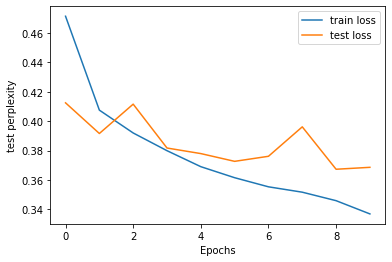

In [26]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(yr, pred, pos_label=1)
print("AUC : ",metrics.auc(fpr, tpr))

from sklearn.metrics import accuracy_score
print("accuracy : ",accuracy_score(yr,pred))

from sklearn.metrics import precision_score
print("precision : ",precision_score(yr, pred))

from sklearn.metrics import recall_score
print("recall : " ,recall_score(yr, pred) )

from sklearn.metrics import f1_score
print("F1 : ", f1_score(yr, pred))

import matplotlib.pyplot as plt
import numpy as np
import math
hist2=history.history
loss=hist2['loss']
val_loss=hist2['val_loss']
plt.xlabel('Epochs')
plt.ylabel('train loss')
plt.plot(loss)

plt.xlabel('Epochs')
plt.ylabel('test perplexity')
plt.plot(val_loss)
plt.legend(['train loss','test loss'])

## **20 epochs**

In [28]:
import keras.backend as K
def initialize_vars(sess):
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)
model2 = create_model()
sess = tf.Session()
# Instantiate variables
initialize_vars(sess)
history2 = model2.fit(x_train, y_train, epochs=20, batch_size=100,validation_data = (x_test,y_test) )

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Train on 25000 samples, validate on 5000 samples
Epoch 1/20
25000/25000 [==============================] - 895s 36ms/step - loss: 0.4782 - accuracy: 0.7699 - val_loss: 0.4206 - val_accuracy: 0.8020
Epoch 2/20
25000/25000 [==============================] - 895s 36ms/step - loss: 0.4090 - accuracy: 0.8119 - val_loss: 0.3914 - val_accuracy: 0.8256
Epoch 3/20
25000/25000 [==============================] - 895s 36ms/step - loss: 0.3953 - accuracy: 0.8212 - val_loss: 0.3883 - val_accuracy: 0.8262
Epoch 4/20
25000/25000 [==============================] - 895s 36ms/step - loss: 0.3845 - accuracy: 0.8263 - val_loss: 0.3792 - val_accuracy: 0.8304
Epoch 5/20
25000/25000 [==============================] - 900s 36ms/step - loss: 0.3698 - accuracy: 0.8350 - val_loss: 0.3943 - val_accuracy: 0.8244
Epoch 6/20
25000/25000 [==============================] - 896s 36ms/step - loss: 0.3619 - accuracy: 0.8409 - val_loss: 0.3735 - val_accuracy: 0.8338
Epoch 7/20
25000/25000 [==============================] -

In [0]:
model2.save_weights('./elmo-model_sent2.h5')
# model2.load_weights('./elmo-model_sent2.h5')

In [0]:
predict2 = model2.predict(x_test)

In [0]:
pred = [np.where(t == np.max(t))[0][0] for t in predict2]
yr = [np.where(t == np.max(t))[0][0] for t in y_test]

AUC :  0.8363159596928168
accuracy :  0.8356
precision :  0.8800533096401599
recall :  0.7820765890248716
F1 :  0.8281772575250836


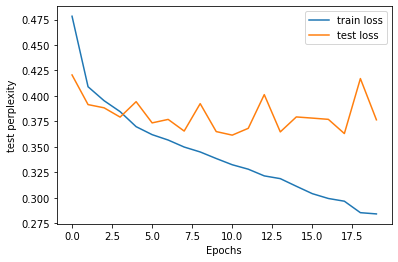

In [31]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(yr, pred, pos_label=1)
print("AUC : ",metrics.auc(fpr, tpr))

from sklearn.metrics import accuracy_score
print("accuracy : ",accuracy_score(yr,pred))

from sklearn.metrics import precision_score
print("precision : ",precision_score(yr, pred))

from sklearn.metrics import recall_score
print("recall : " ,recall_score(yr, pred) )

from sklearn.metrics import f1_score
print("F1 : ", f1_score(yr, pred))

import matplotlib.pyplot as plt
import numpy as np
import math
hist2=history2.history
loss=hist2['loss']
val_loss=hist2['val_loss']
plt.xlabel('Epochs')
plt.ylabel('train loss')
plt.plot(loss)

plt.xlabel('Epochs')
plt.ylabel('test perplexity')
plt.plot(val_loss)
plt.legend(['train loss','test loss'])

## **without preprocessing**

In [15]:
model_pre = create_model()
history_pre = model_pre.fit(x_train, y_train, epochs=10, batch_size=200,validation_data = (x_test,y_test) )

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Train on 25000 samples, validate on 5000 samples
Epoch 1/10
25000/25000 [==============================] - 263s 11ms/step - loss: 0.4977 - accuracy: 0.7550 - val_loss: 0.4443 - val_accuracy: 0.7952
Epoch 2/10
25000/25000 [==============================] - 252s 10ms/step - loss: 0.4342 - accuracy: 0.7951 - val_loss: 0.4268 - val_accuracy: 0.8026
Epoch 3/10
25000/25000 [==============================] - 250s 10ms/step - loss: 0.4181 - accuracy: 0.8071 - val_loss: 0.4650 - val_accuracy: 0.7694
Epoch 4/10
25000/25000 [==============================] - 251s 10ms/step - loss: 0.4060 - accuracy: 0.8143 - val_loss: 0.4112 - val_accuracy: 0.8098
Epoch 5/10
25000/25000 [==============================] - 252s 10ms/step - loss: 0.3981 - accuracy: 0.8191 - val_loss: 0.4024 - val_accuracy: 0.8172
Epoch 6/10
25000/25000 [==============================] - 254s 10ms/step - loss: 0.3882 - accuracy: 0.8240 - val_loss: 0.4062 - val_accuracy: 0.8088
Epoch 7/10
25000/25000 [==============================] -

In [0]:
predict = model_pre.predict(x_test)

In [0]:
pred = [np.where(t == np.max(t))[0][0] for t in predict]
yr = [np.where(t == np.max(t))[0][0] for t in y_test]

AUC :  0.812758613406519
accuracy :  0.8128
precision :  0.8142276422764227
recall :  0.8070104754230459
F1 :  0.810602994738972


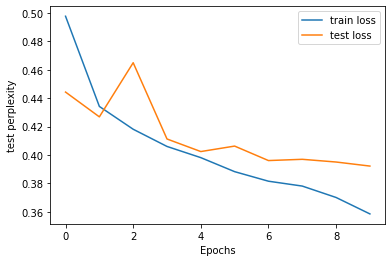

In [18]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(yr, pred, pos_label=1)
print("AUC : ",metrics.auc(fpr, tpr))

from sklearn.metrics import accuracy_score
print("accuracy : ",accuracy_score(yr,pred))

from sklearn.metrics import precision_score
print("precision : ",precision_score(yr, pred))

from sklearn.metrics import recall_score
print("recall : " ,recall_score(yr, pred) )

from sklearn.metrics import f1_score
print("F1 : ", f1_score(yr, pred))

import matplotlib.pyplot as plt
import numpy as np
import math
hist2=history_pre.history
loss=hist2['loss']
val_loss=hist2['val_loss']
plt.xlabel('Epochs')
plt.ylabel('train loss')
plt.plot(loss)

plt.xlabel('Epochs')
plt.ylabel('test perplexity')
plt.plot(val_loss)
plt.legend(['train loss','test loss'])